In [131]:
%reset -f

In [132]:
import anuga
from anuga import create_mesh_from_regions
import numpy as np
from hymo import SWMMInpFile
from pyswmm import Simulation, Nodes, Links
import matplotlib.pyplot as plt
import pandas as pd
from pyswmm import SystemStats
import matplotlib
from coupling_functions.coupling import calculate_Q, calculate_Q_v2
from coupling_functions.inlet_initialization import initialize_inlets
import os
import glob
import anuga.utilities.spatialInputUtil as su

### 
from anuga import Inlet_operator,Region
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})

do_new_coupling   = True
manual_inlet_init = True
do_surf_rain      = False
expand_polygon    = False
zero_velocity     = False

visualise         = True
verbose           = False

time_average = 10 # sec
out_dt       = 2.0 # output step
n_sides      = 4
inlet_area   = 1


rf = 20  # refinement factor for domain, if too coarse the inlets will overlap the wall
# rf = 50  # refinement factor for domain, if too coarse the inlets will overlap the wall

dt = 1     # yield step
ft = 75     # final timestep
cw = 0.6
co = 0.6
basename = 'model/terrain'

if do_surf_rain:
    file_name = 'real_example'
    inp_name = file_name + '.inp'
else:
    file_name = 'real_example_pipe_flow'
    inp_name = file_name + '.inp'



outname  = file_name
meshname = 'model/terrain.tsh'

inp_name = outname + '.inp'
sim = Simulation(inp_name)
inp = SWMMInpFile(inp_name)

baseline_flows = []
if do_surf_rain:
    baseline_flows = [0.5, 0.0, 0.0, 0.0]
else:
    for inflow in inp.inflows.Baseline.values:
        baseline_flows.append(inflow)
baseline_flow  = sum(baseline_flows)
riverWall_csv_files = glob.glob('model/wall/*.csv') # Make a list of the csv files in BREAKLINES

(riverWalls, riverWall_parameters) = su.readListOfRiverWalls(riverWall_csv_files)

CatchmentDictionary = {'model/kerb/kerb1.csv':0.01, 'model/kerb/kerb2.csv':0.01}
    
bounding_polygon = anuga.read_polygon('model/domain.csv')
interior_regions = anuga.read_polygon_dir(CatchmentDictionary, 'model/kerb')


create_mesh_from_regions(bounding_polygon,
    boundary_tags={'inflow': [12], 'bottom': [0,1,2,3,4,5], 'top': [7,8,9,10,11], 'outflow': [6]},
    #boundary_tags=None,
    maximum_triangle_area = 0.5,
    # breaklines = riverWalls.values(),
    # interior_regions = interior_regions,
    filename = meshname,
    use_cache = False,
    verbose = False)


domain = anuga.Domain(meshname, use_cache=False, verbose=False)
# domain.set_minimum_storable_height(0.0)
domain.set_minimum_storable_height(0.0001)
domain.riverwallData.create_riverwalls(riverWalls,verbose = False) 
domain.set_name(outname) 

domain.set_quantity('friction', 0.025)
domain.set_quantity('stage', 0)
domain.set_quantity('elevation', filename=basename+'.csv', use_cache=False, verbose=False, alpha=0.99)

Br = anuga.Reflective_boundary(domain)  
Bd = anuga.Dirichlet_boundary([0,0,0])


domain.set_boundary({'inflow': Bd, 'bottom': Bd, 'outflow': Bd, 'top': Bd})



 o  Retrieving project data

/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


Plot inlets below:

In [133]:
if manual_inlet_init:
    inlet_width        = np.sqrt(inlet_area)
    inlet_weir_lengths = 4.0 * inlet_width
    inlet1_xcoord = inp.coordinates.loc['Inlet_1'].X_Coord
    inlet1_ycoord = inp.coordinates.loc['Inlet_1'].Y_Coord

    inlet1_polygon = [[inlet1_xcoord-inlet_width/2, inlet1_ycoord-inlet_width/2], [inlet1_xcoord+inlet_width/2, inlet1_ycoord-inlet_width/2], [inlet1_xcoord + inlet_width/2, inlet1_ycoord+inlet_width/2], [inlet1_xcoord - inlet_width/2, inlet1_ycoord+inlet_width/2]]
    inlet1_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet1_polygon)


    inlet2_xcoord = inp.coordinates.loc['Inlet_2'].X_Coord
    inlet2_ycoord = inp.coordinates.loc['Inlet_2'].Y_Coord
    inlet2_polygon = [[inlet2_xcoord-inlet_width/2, inlet2_ycoord-inlet_width/2], [inlet2_xcoord+inlet_width/2, inlet2_ycoord-inlet_width/2], [inlet2_xcoord + inlet_width/2, inlet2_ycoord+inlet_width/2], [inlet2_xcoord - inlet_width/2, inlet2_ycoord+inlet_width/2]]
    inlet2_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet2_polygon)

    inlet3_xcoord = inp.coordinates.loc['Inlet_3'].X_Coord
    inlet3_ycoord = inp.coordinates.loc['Inlet_3'].Y_Coord
    inlet3_polygon = [[inlet3_xcoord-inlet_width/2, inlet3_ycoord-inlet_width/2], [inlet3_xcoord+inlet_width/2, inlet3_ycoord-inlet_width/2], [inlet3_xcoord + inlet_width/2, inlet3_ycoord+inlet_width/2], [inlet3_xcoord - inlet_width/2, inlet3_ycoord+inlet_width/2]]
    inlet3_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet3_polygon)

    inlet4_xcoord = inp.coordinates.loc['Inlet_4'].X_Coord
    inlet4_ycoord = inp.coordinates.loc['Inlet_4'].Y_Coord
    
    inlet4_polygon = [[inlet4_xcoord-inlet_width/2, inlet4_ycoord-inlet_width/2], [inlet4_xcoord+inlet_width/2, inlet4_ycoord-inlet_width/2], [inlet4_xcoord + inlet_width/2, inlet4_ycoord+inlet_width/2], [inlet4_xcoord - inlet_width/2, inlet4_ycoord+inlet_width/2]]
    inlet4_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet4_polygon)



    inlet1_anuga_inlet_op = anuga.Inlet_operator(domain, inlet1_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    inlet2_anuga_inlet_op = anuga.Inlet_operator(domain, inlet2_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    inlet3_anuga_inlet_op = anuga.Inlet_operator(domain, inlet3_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    inlet4_anuga_inlet_op = anuga.Inlet_operator(domain, inlet4_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    inlet_operators = {'Inlet_1':inlet1_anuga_inlet_op, 'Inlet_2':inlet2_anuga_inlet_op, 'Inlet_3':inlet3_anuga_inlet_op, 'Inlet_4':inlet4_anuga_inlet_op}

    if do_surf_rain:
        baseline_flow = 0.5
        rain_operators   = anuga.Inlet_operator(domain, inlet1_anuga_region, Q = baseline_flow, zero_velocity=zero_velocity)
    else:
        rain_operators   = anuga.Inlet_operator(domain, inlet1_anuga_region, Q = 0.0, zero_velocity=zero_velocity)


    inlet_elevation = np.array([inlet1_anuga_inlet_op.inlet.get_average_elevation(),
                        inlet2_anuga_inlet_op.inlet.get_average_elevation(),
                        inlet3_anuga_inlet_op.inlet.get_average_elevation(),
                        inlet4_anuga_inlet_op.inlet.get_average_elevation()])
    swmm_inlet1 = Nodes(sim)['Inlet_1']
    swmm_inlet2 = Nodes(sim)['Inlet_2']
    swmm_inlet3 = Nodes(sim)['Inlet_3']
    swmm_inlet4 = Nodes(sim)['Inlet_4']

    swmm_culvert1 = Links(sim)['Conduit_1']
    swmm_culvert2 = Links(sim)['Conduit_2']
    swmm_culvert3 = Links(sim)['Conduit_3']
    culvert4 = Links(sim)['Conduit_4']
    link_volume_0 = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + culvert4.volume

else: # ~manual_inlet_init       
    inlet_operators,inlet_elevation,inlet_weir_lengths,inlet_vertices = initialize_inlets(domain,sim,inp,n_sides,
                                                                        len(baseline_flows)*[inlet_area], len(baseline_flows)*[0.0],
                                                                        rotation = -np.pi/4, zero_velocity = zero_velocity, expand_polygon = expand_polygon)

    if do_surf_rain:
        baseline_flows = [0.5, 0.0, 0.0, 0.0]
        baseline_flow = sum(baseline_flows)
        rain_operators,inlet_elevation,_,_ = initialize_inlets(domain, sim, inp, n_sides, len(baseline_flows)*[inlet_area], baseline_flows, zero_velocity = zero_velocity, expand_polygon = expand_polygon)
    else:
        rain_operators,_,_,_ = initialize_inlets(domain, sim, inp, n_sides, len(baseline_flows)*[inlet_area], len(baseline_flows)*[0.0], zero_velocity = zero_velocity, expand_polygon = expand_polygon)

    link_volume_0 = sum(link.volume for link in Links(sim))

In [134]:
n_sides

4

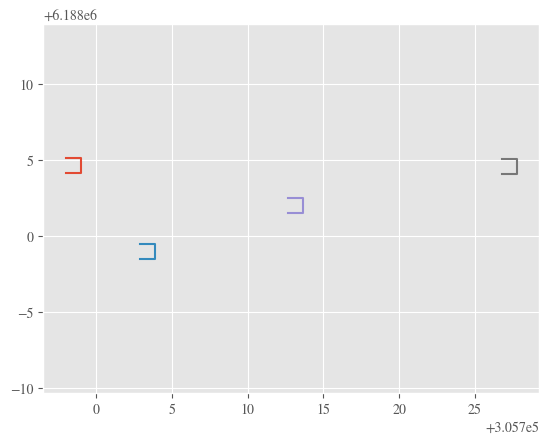

In [135]:
if manual_inlet_init:
    plt.plot(np.array(inlet1_polygon)[:,0],np.array(inlet1_polygon)[:,1])
    plt.plot(np.array(inlet2_polygon)[:,0],np.array(inlet2_polygon)[:,1])
    plt.plot(np.array(inlet3_polygon)[:,0],np.array(inlet3_polygon)[:,1])
    plt.plot(np.array(inlet4_polygon)[:,0],np.array(inlet4_polygon)[:,1])
    plt.axis('equal')

else:
    plt.plot(np.array(inlet_vertices[0])[:,0],np.array(inlet_vertices[0])[:,1])
    plt.plot(np.array(inlet_vertices[1])[:,0],np.array(inlet_vertices[1])[:,1])
    plt.plot(np.array(inlet_vertices[2])[:,0],np.array(inlet_vertices[2])[:,1])
    plt.plot(np.array(inlet_vertices[3])[:,0],np.array(inlet_vertices[3])[:,1])

    plt.axis('equal')


In [136]:
inlet_weir_lengths

4.0

In [137]:
system_routing = SystemStats(sim)
conduit_depth_list = []
inlet1_flood_flows = []
outlet_flood_flows = []
outlet_lateral_vol = []
inlet_lateral_vol  = []
outlet_flood_vol   = []
inlet_flood_vol    = []
node_head_list     = []
external_flows     = []
domain_volumes     = []
outfall_flows      = []
sewer_volumes      = []
correct_vols       = []
outlet_flows       = []
inlet_flows        = []
time_series        = []
Q_in_cumus         = []
real_vols          = []
anuga_ws           = []
losses             = []
Q_ins              = []
H_js               = []
Q_in_old = np.array([0.0, 0.0, 0.0, 0.0])

old_inlet_vol = len(baseline_flows)*[0.0]

cumulative_inlet_flooding  = 0.0
cumulative_outlet_flooding = 0.0
cumulative_inlet_flow      = 0.0
cumulative_outlet_flow     = 0.0
cumulative_outfall_vol    = 0.0
Q_in_cumu = 0
old_outlet_vol = 0.0
old_inlet1_vol = 0.0
old_inlet2_vol = 0.0
old_inlet3_vol = 0.0
old_inlet1_flood   = 0
old_inlet2_flood   = 0
old_inlet3_flood   = 0
old_outlet_flood   = 0
link_volume = link_volume_0
in_node_ids = [node.nodeid for node in Nodes(sim) if node.is_junction()]

inlet_cell_vols = []
inlet_cell_vols2 = []
anuga_depths_list = []
anuga_depths_list2 = []
node_heads_list = []
node_heads_list2 = []

In [151]:
inp.options

,Value
Option,
FLOW_UNITS,CMS
INFILTRATION,HORTON
FLOW_ROUTING,DYNWAVE
LINK_OFFSETS,DEPTH
MIN_SLOPE,0
ALLOW_PONDING,NO
SKIP_STEADY_STATE,NO
START_DATE,09/08/2022
START_TIME,00:00:00


In [138]:
for node in Nodes(sim):
    print(node.nodeid)

Inlet_1
Inlet_2
Inlet_3
Inlet_4
Outfall_1


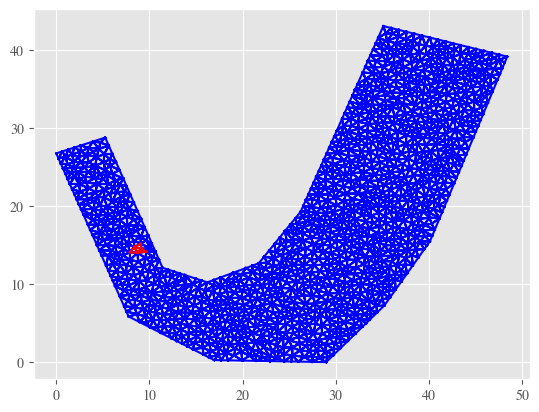

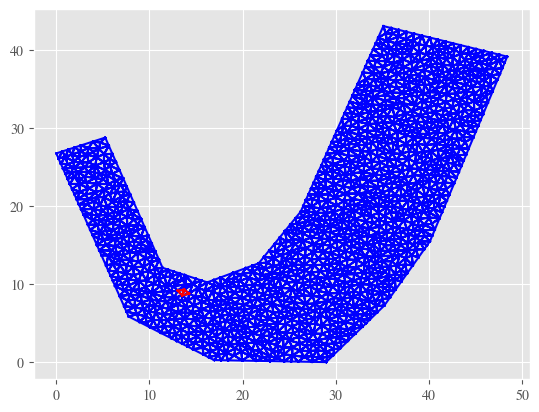

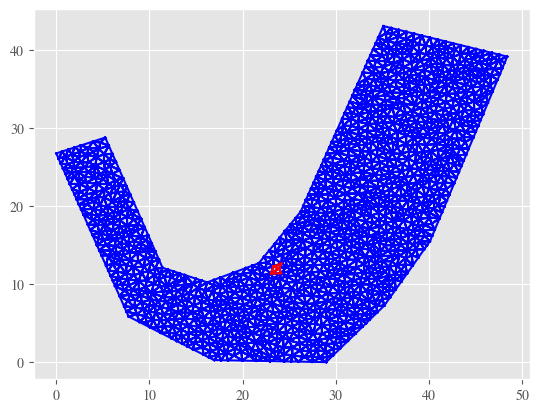

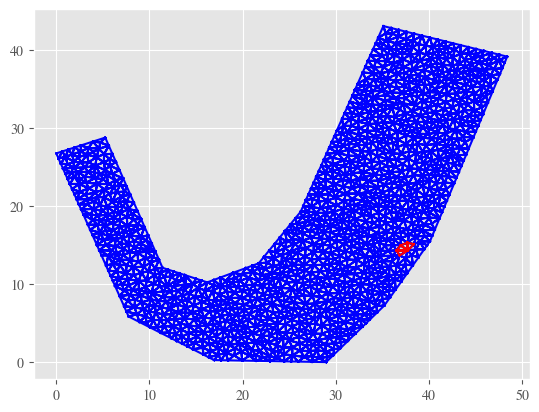

In [139]:
for node in Nodes(sim):
    if node.is_junction():
        inlet_operators[node.nodeid].inlet.region.plot_region()

In [140]:
outfall_vol = 0

In [141]:
sim.start()
domain.output_frequency = 100
for t in domain.evolve(yieldstep=dt, outputstep=out_dt, finaltime=ft):


    anuga_depths = np.array([inlet_operators[in_id].inlet.get_average_depth() for in_id in in_node_ids])

    link_volume = sum([link.volume for link in Links(sim)])
    node_volume = sum([node.volume for node in Nodes(sim)])
    domain_volume        = domain.get_water_volume()
    sewer_volume         = link_volume + node_volume
    boundary_flux        = domain.get_boundary_flux_integral() # actually volume
    outfall_vol         += Nodes(sim)['Outfall_1'].total_inflow*dt

    # total_volume_correct = t*sum(baseline_flows) + 0.5*sum(baseline_flows) + boundary_flux + link_volume_0 - outfall_vol 
    total_volume_correct = t*sum(baseline_flows) + boundary_flux + link_volume_0 - outfall_vol 

    total_volume_real    = domain_volume + sewer_volume

    loss                 = total_volume_real - total_volume_correct
    applied_inflow       = (system_routing.routing_stats["external_inflow"] - Q_in_cumu)*dt

    node_head = np.array([node.head for node in Nodes(sim) if node.is_junction()])
    # node_volume = 0.0
    # sewer_volume = link_volume + node_volume

    # boundary_flux        = domain.get_boundary_flux_integral()
    # domain_volume        = domain.get_water_volume()
    # total_volume_correct = baseline_flow * t + 0.5*baseline_flow + boundary_flux  + link_volume_0 - cumulative_outfall_vol
    # total_volume_real    = domain_volume + sewer_volume
    # loss                 = total_volume_real - total_volume_correct
    if manual_inlet_init:
        anuga_depths = np.array([inlet1_anuga_inlet_op.inlet.get_average_depth(),
                                inlet2_anuga_inlet_op.inlet.get_average_depth(),
                                inlet3_anuga_inlet_op.inlet.get_average_depth(),
                                inlet4_anuga_inlet_op.inlet.get_average_depth()])
        link_volume = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + culvert4.volume
        inlet1_head  = swmm_inlet1.head
        inlet2_head  = swmm_inlet2.head
        inlet3_head  = swmm_inlet3.head
        inlet4_head  = swmm_inlet4.head
        node_heads   = np.array([inlet1_head, inlet2_head, inlet3_head, inlet4_head])
        inlet_volumes = [inlet1_anuga_inlet_op.inlet.get_total_water_volume(),inlet2_anuga_inlet_op.inlet.get_total_water_volume(),inlet3_anuga_inlet_op.inlet.get_total_water_volume(), inlet4_anuga_inlet_op.inlet.get_total_water_volume()]
        cumulative_inlet_flooding += swmm_inlet1.flooding*dt 
        cumulative_outlet_flooding += swmm_inlet4.flooding*dt

    else: # ~manual_inlet_init
        anuga_depths = np.array([inlet_operators[node.nodeid].inlet.get_average_depth() for node in Nodes(sim) if node.is_junction()])
        link_volume = sum([link.volume for link in Links(sim)])
        node_heads    = np.array([node.head for node in Nodes(sim) if node.is_junction()])
        inlet_volumes = [inlet_operators[node.nodeid].inlet.get_total_water_volume() for node in Nodes(sim) if node.is_junction()]

    if do_new_coupling:
        Q_in     = calculate_Q_v2(node_heads, anuga_depths, inlet_elevation, inlet_weir_lengths, inlet_area, inlet_volumes = inlet_volumes, dt = dt, cw = cw, co = co)
    else:
        Q_in     = calculate_Q(node_heads, anuga_depths, inlet_elevation, inlet_weir_lengths, inlet_area, cw = cw, co = co)

    Q_in     = ((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old = Q_in
    Q_ins.append(Q_in.copy())
    Q_in_cumu += sum(Q_in)
    Q_in_cumus.append(Q_in_cumu)

    if manual_inlet_init:
        swmm_inlet1.generated_inflow(Q_in[0])
        swmm_inlet2.generated_inflow(Q_in[1])
        swmm_inlet3.generated_inflow(Q_in[2])
        swmm_inlet4.generated_inflow(Q_in[3])
    else: # ~manual_inlet_init
        for nodeid, Qin in zip(in_node_ids, Q_in):
            Nodes(sim)[nodeid].generated_inflow(Qin)    

    sim.step_advance(dt)
    sim.next()

    if manual_inlet_init:
        inlet1_vol = - swmm_inlet1.statistics['lateral_infow_vol'] + swmm_inlet1.statistics['flooding_volume']
        inlet1_flow = (inlet1_vol - old_inlet1_vol)/dt
        old_inlet1_vol = inlet1_vol
        inlet2_vol = - swmm_inlet2.statistics['lateral_infow_vol'] + swmm_inlet2.statistics['flooding_volume'] 
        inlet2_flow = (inlet2_vol - old_inlet2_vol)/dt
        old_inlet2_vol = inlet2_vol
        inlet3_vol = - swmm_inlet3.statistics['lateral_infow_vol'] + swmm_inlet3.statistics['flooding_volume'] 
        inlet3_flow = (inlet3_vol - old_inlet3_vol)/dt
        old_inlet3_vol = inlet3_vol
        outlet_vol = - swmm_inlet4.statistics['lateral_infow_vol'] + swmm_inlet4.statistics['flooding_volume'] 
        outlet_flow = (outlet_vol - old_outlet_vol)/dt
        old_outlet_vol = outlet_vol

        inlet_flows.append(inlet1_flow)
        outlet_flows.append(outlet_flow)

        cumulative_inlet_flow += inlet1_flow*dt
        cumulative_outlet_flow += outlet_flow*dt

        if do_surf_rain:
            inlet1_anuga_inlet_op.set_Q(inlet1_flow)
        else: # ~surf_rain
            inlet1_anuga_inlet_op.set_Q(inlet1_flow + baseline_flow)

        inlet2_anuga_inlet_op.set_Q(inlet2_flow)
        inlet3_anuga_inlet_op.set_Q(inlet3_flow)
        # inlet4_anuga_inlet_op.set_Q(outlet_flow + swmm_outfall.total_inflow)
        inlet4_anuga_inlet_op.set_Q(outlet_flow)


    else: # ~manual_inlet_init
        inlet_vol       = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]
        inlet_flow      = [(new_vol - old_vol)/dt for new_vol, old_vol in zip(inlet_vol,old_inlet_vol)]
        old_inlet_vol   = inlet_vol.copy()

        inlet_idx = 0

        if do_surf_rain:
            for node in Nodes(sim):
                if node.is_junction():
                    inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx])
                    inlet_idx += 1
        else: # ~surf_rain
            for node in Nodes(sim):
                if node.is_junction():
                    inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx] + baseline_flows[inlet_idx])
                    inlet_idx += 1

    cumulative_outfall_vol += Nodes(sim)['Outfall_1'].total_inflow*dt
    outfall_flows.append(Nodes(sim)['Outfall_1'].total_inflow)
    print_out = domain.yieldstep_counter%domain.output_frequency == 0


    external_flows.append(system_routing.routing_stats['external_inflow'])
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)
    domain_volumes.append(domain_volume)
    sewer_volumes.append(sewer_volume)
    time_series.append(t)
    losses.append(loss)

    if print_out:
        domain.print_timestepping_statistics()
        print(inlet_volumes)


# sim.close()


Time = 0.0000 (sec), steps=0 (3s)
[0.0, 0.0, 0.0, 0.0]


In [142]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 21/03/2023 10:17:23


In [143]:
print(f'cw,co: {cw}, {co}')
print(f'Inlet area: {inlet_area}')
print(f'Do new coupling: {do_new_coupling}')
print(20*'#')
print(f'Manual inlet initialization: {manual_inlet_init}')
print(f'Rain on surface: {do_surf_rain}')
print(f'Expand polygon: {expand_polygon}')
print(f'Zero velocity: {zero_velocity}')


cw,co: 0.6, 0.6
Inlet area: 1
Do new coupling: True
####################
Manual inlet initialization: True
Rain on surface: False
Expand polygon: False
Zero velocity: False


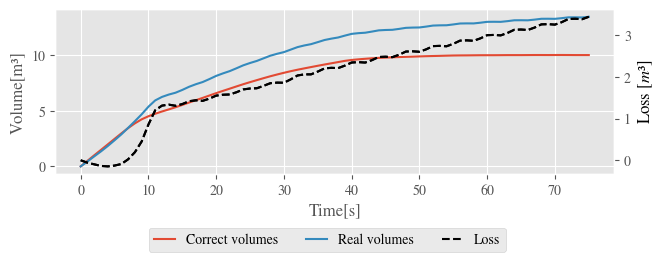

In [144]:
inch = 2.54
fig_size = 17

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(time_series,correct_vols,label = 'Correct volumes')
ax.plot(time_series,real_vols, label = 'Real volumes')
ax.set_xlabel('Time[s]')
ax.set_ylabel('Volume[m³]')

diff_ax = ax.twinx()
diff_ax.plot(time_series,losses,label = 'Loss',color = 'k',linestyle = '--')
diff_ax.plot(time_series,np.array(real_vols)- np.array(correct_vols),label = 'Loss',color = 'k',linestyle = '--')

diff_ax.grid(False)
diff_ax.set_ylabel('Loss [$m³$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))

diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Loss')


fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)
if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    if do_surf_rain:

        if do_new_coupling:
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')

        else: 
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')
    else:

        if do_new_coupling:
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')

        else: 
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')


In [145]:
loss

3.4350179207468763

In [146]:
loss

3.4350179207468763

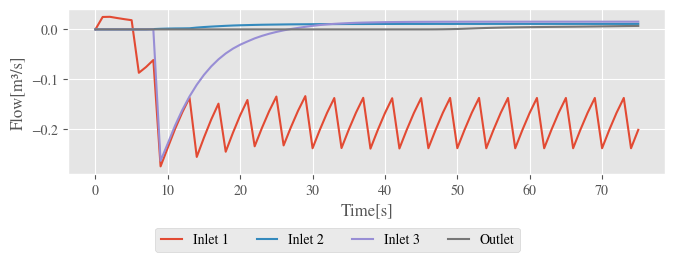

In [147]:

inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(Q_ins,label = ['Inlet 1' , 'Inlet 2', 'Inlet 3', 'Outlet'])
ax.set_xlabel('Time[s]')
ax.set_ylabel('Flow[m³/s]')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)